## Inspect data for preprocessing

In [28]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import sys
import numpy as np

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset

In [3]:
lev=0
data_full=xr.open_zarr(fsspec.get_mapper(f'/scratch/zanna/data/pyqg/publication/eddy/forcing1.zarr'), consolidated=True)
data_dqbar=data_full.dqbar_dt.isel(lev=0)
data_dqbar=data_dqbar.stack(snapshot=("run","time"))
data_dqbar=data_dqbar.transpose("snapshot","y","x")
data_forcing=data_full.q_subgrid_forcing.isel(lev=lev)
data_forcing=data_forcing.stack(snapshot=("run","time"))
data_forcing=data_forcing.transpose("snapshot","y","x")
data_q=data_full.q.isel(lev=0)
data_q=data_q.stack(snapshot=("run","time"))
data_q=data_q.transpose("snapshot","y","x")

In [4]:
dqbar=data_dqbar.to_numpy()
q=data_q.to_numpy()
forcing=data_forcing.to_numpy()

In [5]:
dqbar.shape

(23925, 64, 64)

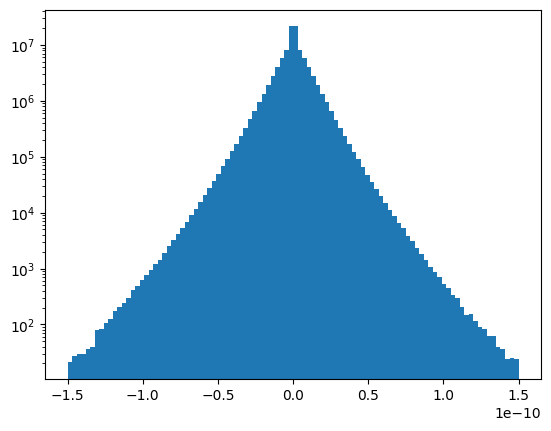

In [6]:
plt.hist(dqbar.flatten(),bins=100,range=[-1.5e-10,1.5e-10]);
plt.yscale("log")

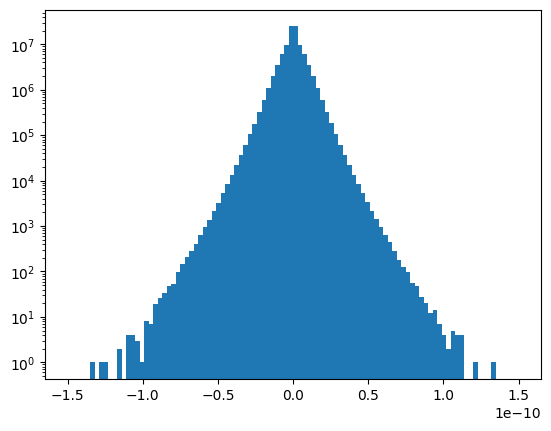

In [7]:
plt.hist(forcing.flatten(),bins=100,range=[-1.5e-10,1.5e-10]);
plt.yscale("log")

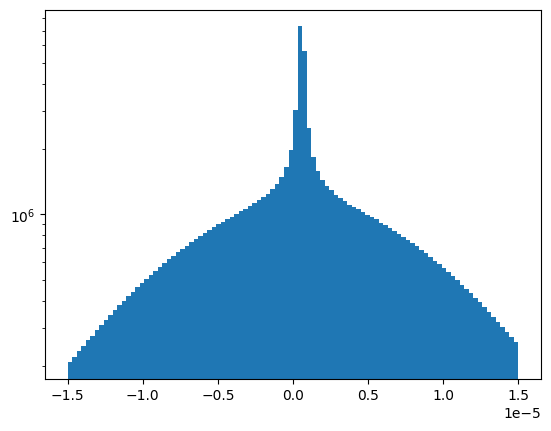

In [8]:
plt.hist(q.flatten(),bins=100,range=[-1.5e-5,1.5e-5]);
plt.yscale("log")

In [9]:
q_torch=torch.tensor(q)

In [10]:
q_torch.shape

torch.Size([23925, 64, 64])

In [11]:
q_torch.std()

tensor(7.8604e-06)

In [12]:
preprocess = T.Compose([T.Normalize(
       mean=[5.5053e-07],
       std=[7.8604e-06])])

In [13]:
q_prep=preprocess(q_torch)

In [14]:
q_prep.numpy()

array([[[-1.98915089e-03,  2.02534012e-02,  3.47131751e-02, ...,
          2.24943776e-02,  2.79610567e-02, -2.54336046e-05],
        [-1.51114806e-03,  1.99362729e-02,  3.35807540e-02, ...,
          2.37882677e-02,  2.80002505e-02, -7.06022984e-05],
        [-2.18026806e-03,  1.89790297e-02,  3.30633484e-02, ...,
          2.40368750e-02,  2.78443657e-02, -4.75818844e-04],
        ...,
        [-2.48227501e-03,  1.96601413e-02,  3.32514048e-02, ...,
          2.28170529e-02,  2.82249879e-02, -3.52714997e-04],
        [-3.33121652e-03,  1.93540771e-02,  3.41544040e-02, ...,
          2.16761418e-02,  2.79928464e-02, -5.81530679e-04],
        [-2.83294357e-03,  1.97979324e-02,  3.50433998e-02, ...,
          2.16128584e-02,  2.82749087e-02,  5.64138609e-05]],

       [[ 2.11475119e-02,  5.32321678e-03,  5.52556477e-03, ...,
         -1.41448807e-02, -3.68247787e-03,  3.06305140e-02],
        [ 2.10171025e-02,  6.16431190e-03,  5.93943009e-03, ...,
         -1.52143184e-02, -4.25678398e

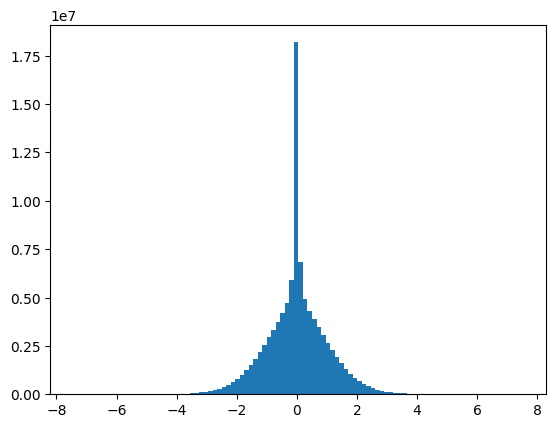

In [17]:
plt.hist(q_prep.numpy().flatten(),bins=100);

In [26]:
class ForcingDataset(Dataset):
    """
    Subgrid forcing maps dataset
    """
    def __init__(self,x_xarr,y_xarr,seed=42,normalise=True,train_ratio=0.75,valid_ratio=0.25,test_ratio=0.0):
        """
        pv:          xarray of the PV field
        dqbar_dt:    xarray of PV tendency
        s:           xarray of the subgrid forcing field
        seed:        random seed used to create train/valid/test splits
        normalise:   bool, normalise mean and variance of fields
        train_ratio: proportion of dataset to use as training data
        valid_ratio: proportion of dataset to use as validation data
        test_ratio:  proportion of dataset to use as test data
        
        """
        super().__init__()
        self.normalise=normalise
        self.x_data=torch.unsqueeze(torch.tensor(x_xarr.to_numpy()),dim=1)
        self.y_data=torch.unsqueeze(torch.tensor(y_xarr.to_numpy()),dim=1)
        self.train_ratio=train_ratio
        self.valid_ratio=valid_ratio
        self.test_ratio=test_ratio
        self.rng = np.random.default_rng(seed)

        self.x_renorm=torch.std(self.x_data)
        self.y_renorm=torch.std(self.y_data)
        self.x_data=self.x_data/self.x_renorm
        self.y_data=self.y_data/self.y_renorm
        self.len=len(self.x_data)
        
        assert len(self.x_data)==len(self.y_data), "Number of x and y samples should be the same"
        
        self._get_split_indices()
        
    def _get_split_indices(self):
        """ Set indices for train, valid and test splits """

        ## Randomly shuffle indices of entire dataset
        rand_indices=self.rng.permutation(np.arange(self.len))

        ## Set number of train, valid and test points
        num_train=math.floor(self.len*self.train_ratio)
        num_valid=math.floor(self.len*self.valid_ratio)
        num_test=math.floor(self.len*self.test_ratio)
        
        ## Make sure we aren't overcounting
        assert (num_train+num_valid+num_test) <= self.len
        
        ## Pick train, test and valid indices from shuffled list
        self.train_idx=rand_indices[0:num_train]
        self.valid_idx=rand_indices[num_train+1:num_train+num_valid]
        self.test_idx=rand_indices[len(self.valid_idx)+1:]
        
        ## Make sure there's no overlap between train, valid and test data
        assert len(set(self.train_idx) & set(self.valid_idx) & set(self.test_idx))==0, (
                "Common elements in train, valid or test set")
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.x_data[idx],self.y_data[idx])

In [27]:
dataset=ForcingDataset(data_q,data_forcing,seed=123)

NameError: name 'np' is not defined